In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [144]:
%load_ext autoreload
%autoreload 2
from utils import *

import numpy as np
import pandas as pd
from tqdm import tqdm
from datetime import datetime
from datetime import timedelta
import matplotlib.pyplot as plt
import os
import lightgbm as lgbm
import warnings
from utils import *
import seaborn as sns
from sklearn.metrics import accuracy_score
from parameters import top_tickers, ibkr_info

sns.set()

warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [222]:
load_tickers(data_prefix="../ssd/finance_data", tickers=np.array(list(ibkr_info.keys()))[:], start_date=datetime.strptime("20190101", "%Y%m%d").date(), end_date=datetime.today().date() + timedelta(days=1), period=2)

100%|██████████| 30/30 [10:56<00:00, 21.88s/it]


In [225]:
ticker2df = load_dfs('../ssd/finance_data', np.array(list(ibkr_info.keys())))

In [211]:
ticker2df = load_dfs('../ssd/finance_data', ['MOEX', 'AFLT'])

In [228]:
len(ticker2df)

30

In [226]:
val_start_date = np.datetime64(datetime.strptime("20200526", "%Y%m%d").date() - timedelta(days=30))
test_start_date = np.datetime64(datetime.strptime("20200526", "%Y%m%d").date() - timedelta(days=15))

all_train_datetimes = df_between(ticker2df['AFLT'], None, val_start_date)['datetime'].values
all_val_datetimes = df_between(ticker2df['AFLT'], val_start_date, test_start_date)['datetime'].values

train_datetimes = np.random.choice(all_train_datetimes, 10)

In [208]:
X, y = single_ticker(df, train_datetimes, np.timedelta64(1,'h'))

In [ ]:
X, y = all_samples(ticker2df, datetimes, np.timedelta64(1,'h'))

In [236]:
X.shape

(150, 100)

(array([ 3.,  8., 13., 20., 60., 23., 14.,  3.,  3.,  3.]),
 array([-0.01019126, -0.00811713, -0.006043  , -0.00396888, -0.00189475,
         0.00017938,  0.00225351,  0.00432764,  0.00640177,  0.0084759 ,
         0.01055002]),
 <a list of 10 Patch objects>)

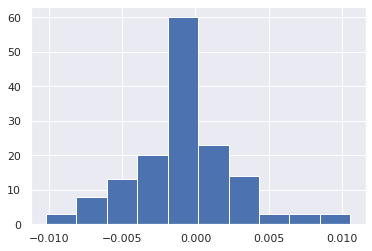

In [240]:
plt.hist(y)

In [147]:
train_df['datetime'].max()

Timestamp('2020-03-18 12:36:00')

In [148]:
curr_datetime

numpy.datetime64('2020-03-18T12:37:00.000000000')

In [151]:
target_df['datetime'].min()

Timestamp('2020-03-18 12:37:00')

In [ ]:
train_df['datetime'].max()

In [ ]:
ticker_feats, ticker_targets = single_ticker(ticker2df['AFKS'], train_dates[:50], False)

In [11]:
feats

,0,1,2,3,4,5,6,7,8,9,...,119,120,121,122,123,124,125,126,ticker,corn_date
0,0.002727,0.023373,1.013984,0.951887,1.01934,0.117925,0.037736,0.007607,1.000326,0.986642,...,0.000926,0.004177,0.000766,0.000457,0.001383,0.000436,0.000458,0.000766,AFKS,2018-05-11


In [ ]:
ticker_feats.shape

In [ ]:
len(ticker_targets)

In [ ]:
feats

In [ ]:
X_train, train_target_dfs = all_samples(ticker2df, train_dates)
X_val, val_target_dfs = all_samples(ticker2df, val_dates)

In [8]:
train_target_dfs[0]

NameError: name 'train_target_dfs' is not defined

In [ ]:
X_train.shape

In [ ]:
best_feat_idxs = np.argsort(lgb.feature_importances_)[::-1][:5]

In [ ]:
lgb.feature_importances_.shape

In [ ]:
best_feat_idxs = [0, 122, 123, 124, 125, 126]

In [ ]:
best_feat_idxs

In [ ]:
y_train = calc_target(train_target_dfs, single_target_3, target_df_2_free_day_series) > 0.01
y_val = calc_target(val_target_dfs, single_target_3, target_df_2_free_day_series) > 0.01

lgb = lgbm.sklearn.LGBMClassifier()
lgb.fit(X_train.drop(['corn_date', 'ticker'], axis=1)[best_feat_idxs], y_train)

In [ ]:
lgb.feature_importances_

In [ ]:
plt.plot(lgb.feature_importances_)

In [ ]:
plt.plot(lgb.feature_importances_)

In [ ]:
try:
    del X_val['profit']
    del X_val['profit_abs']
except:
    None

pred_proba = lgb.predict_proba(X_val.drop(['corn_date', 'ticker'], axis=1)[best_feat_idxs])[:, 1]
#pred_proba = lgb.predict(X_val.drop(['corn_date', 'ticker'], axis=1))

plt.plot(pred_proba)
plt.show()

# pred_proba_2 = lgb_2.predict_proba(X_val.drop(['corn_date', 'ticker'], axis=1))[:, 1]
# plt.plot(pred_proba_2)
# plt.show()

# pred_proba_3 = lgb_3.predict_proba(X_val.drop(['corn_date', 'ticker'], axis=1))[:, 1]
# plt.plot(pred_proba_3)

In [ ]:
plt.hist(pred_proba, bins=100)
plt.show()

In [ ]:
top_idxs = np.where(pred_proba > 0.7)[0]
len(top_idxs)

In [ ]:
y_val.mean(), y_val[top_idxs].mean()

In [ ]:
y_val.mean(), y_val[top_idxs].mean()

In [ ]:
from utils import *

y_val_profit = calc_target(val_target_dfs, single_profit_2, target_df_2_one_day_series)

In [ ]:
X_val['profit'] = y_val_profit
day_cnt_df = X_val.loc[top_idxs].groupby('corn_date').size().reset_index().rename({0:'cnt_per_day'}, axis=1)
X_val = pd.merge(X_val, day_cnt_df, on='corn_date', how='left')
X_val['volume'] = 2500000 / X_val['cnt_per_day']
X_val['profit_abs'] = X_val['volume'] * X_val['profit']
del X_val['cnt_per_day']
del X_val['volume']

In [ ]:
X_val.loc[top_idxs].groupby('corn_date')['profit_abs'].sum()

In [ ]:
X_val.loc[top_idxs]['profit_abs'].sum()

In [ ]:
54294.45376124319
45058.54288341864

In [ ]:
249540.7438308383
238265.8202385087
182758.77619388318
124229.31720323926
91517.8617101984
84287.5011097007

In [ ]:
X_day = X_val.loc[top_idxs]
X_day = X_day[X_day['corn_date'] == datetime.strptime("20190814", "%Y%m%d").date()]

In [ ]:
X_day

In [ ]:
profit

In [ ]:
idx = 237
#for idx in top_idxs:
corn_date = X_val.loc[idx]['corn_date']
ticker = X_val.loc[idx]['ticker']

df = ticker2df[ticker]
month_series = df_between(df, corn_date - timedelta(days=31), corn_date)['<OPEN>'].values
target_series = df_between(df, corn_date, corn_date + timedelta(days=1))['<OPEN>'].values


plt.figure(figsize=(25,10))
plt.title(ticker)
plt.plot(range(len(month_series)), month_series)
plt.plot(range(len(month_series), len(month_series) + len(target_series)), target_series)

buy_idx, sell_idx, profit = single_profit_2(target_series, return_idxs=True)

plt.scatter(len(month_series) + 1, target_series[0], color='k')
plt.scatter(len(month_series) + buy_idx, target_series[buy_idx], color='g')
plt.scatter(len(month_series) + sell_idx, target_series[sell_idx], color='r')

#plt.plot(range(len(month_series), len(month_series) + len(target_series)), y_val_series[84][-8], color='r')




plt.show()
corn_date

In [ ]:
int(datetime.now().strftime('%H'))

In [ ]:
lgb

In [ ]:
import pickle
with open('models/lgb_26_09_thr04.pickle', 'wb') as f:
    pickle.dump(lgb, f)

# Inference

In [ ]:
train_dates = [datetime.today().date() - timedelta(days=x) for x in range(1, 100)]

In [ ]:
X_train, y_train_series = all_samples(ticker2df, train_dates)


In [ ]:
y_train_profit = calc_target(y_train_series, single_profit_2) 

y_train = calc_target(y_train_series, single_target_3) > 0.01

lgb = lgbm.sklearn.LGBMClassifier()
lgb.fit(X_train.drop(['corn_date', 'ticker'], axis=1), y_train)

In [ ]:
test_start_day

In [ ]:
load_tickers(data_prefix="data/current", tickers=np.array(list(ibkr_info.keys())), start_date=datetime.today().date() - timedelta(days=40), end_date=datetime.today().date(), period=3)

In [ ]:
ticker2df_test = load_dfs('data/current', np.array(list(ibkr_info.keys())))

In [ ]:
X_test, y_test_series = all_samples(ticker2df_test, [datetime.today().date()], test_mode=True)

In [ ]:
import pickle
with open('models/lgb_26_09_thr04.pickle', 'rb') as f:
    lgb = pickle.load(f)

In [ ]:
X_test

In [ ]:
# del X_test['profit']
# del X_test['profit_abs']

In [ ]:
pred_proba = lgb.predict_proba(X_test.drop(['corn_date', 'ticker'], axis=1))[:, 1]
plt.plot(pred_proba)
plt.show()


In [ ]:
16990000 * 0.039235

In [ ]:
top_idxs = np.where(pred_proba > 0.25)[0]
top_idxs

In [ ]:
ticker2price = {}

for ticker in list(X_test.loc[top_idxs, ['ticker', 'corn_date']]['ticker'].values):
    
    df = ticker2df_test[ticker]
    price = df[df['date']==datetime.today().date()]['<OPEN>'].values[0]
    
    ticker2price[ticker] = price


ticker2price

In [ ]:
y_test_profit = calc_target(y_test_series, single_profit_2)

In [ ]:
X_test['profit'] = y_test_profit
day_cnt_df = X_test.loc[top_idxs].groupby('corn_date').size().reset_index().rename({0:'cnt_per_day'}, axis=1)
X_test = pd.merge(X_test, day_cnt_df, on='corn_date', how='left')
X_test['volume'] = 2000000 / X_test['cnt_per_day']
X_test['profit_abs'] = X_test['volume'] * X_test['profit']
del X_test['cnt_per_day']
del X_test['volume']

In [ ]:
top_idxs

In [ ]:
X_test.loc[top_idxs, ['ticker', 'corn_date']]

In [ ]:
X_test.loc[top_idxs, ['ticker', 'corn_date', 'profit', 'profit_abs']]

In [ ]:
X_test.loc[top_idxs, ['profit']].sum()

In [ ]:
X_test.loc[top_idxs, ['profit_abs']].sum()

In [ ]:
idx = 20
#for idx in top_idxs:
corn_date = X_test.loc[idx]['corn_date']
ticker = X_test.loc[idx]['ticker']

df = ticker2df_test[ticker]
month_series = df_between(df, corn_date - timedelta(days=31), corn_date)['<OPEN>'].values
target_series = df_between(df, corn_date, corn_date + timedelta(days=1))['<OPEN>'].values


plt.figure(figsize=(25,10))
plt.title(ticker)
plt.plot(range(len(month_series)), month_series)
plt.plot(range(len(month_series), len(month_series) + len(target_series)), target_series)

buy_idx, sell_idx = single_profit_2(np.array([0] + list(target_series)), return_idxs=True)
plt.scatter(len(month_series) + 1, target_series[0], color='k')
plt.scatter(len(month_series) + buy_idx - 1, target_series[buy_idx - 1], color='g')
plt.scatter(len(month_series) + sell_idx - 1, target_series[sell_idx - 1], color='r')

#plt.plot(range(len(month_series), len(month_series) + len(target_series)), y_val_series[84][-8], color='r')

# plt.axhline(y=11.573, linewidth=4, color='g')
# plt.axhline(y=11.675, linewidth=4, color='r')



plt.show()



In [ ]:
    series = np.array([0] + list(target_series))
    UPPER_COEF = 1.003
    BUY_HORIZON = 118
    can_buy = (series[2:BUY_HORIZON] <= series[1]*UPPER_COEF).max()

In [ ]:
can_buy

In [ ]:
series[2:BUY_HORIZON] <= series[1]*UPPER_COEF

In [ ]:
series

In [ ]:
datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')

In [ ]:
data_prefix='data/train'
start_date=datetime.today().date() - timedelta(days=1)
end_date = datetime.today().date() + timedelta(days=1)

ticker='LKOH'
load_single(ticker, 'data/temp', start_date, end_date, 3)


df = pd.read_csv('data/train/{}.csv'.format(ticker))
df['date'] = df['<DATE>'].apply(lambda x: datetime.strptime(str(x), "%Y%m%d").date())

upd_df = pd.read_csv('data/temp/{}.csv'.format(ticker))
upd_df['date'] = upd_df['<DATE>'].apply(lambda x: datetime.strptime(str(x), "%Y%m%d").date())